## GPT
This notebook mainly implements GPT from nanoGPT.


Full definition of a GPT Language Model, all of it in this single file.
References:
1) the official GPT-2 TensorFlow implementation released by OpenAI:
https://github.com/openai/gpt-2/blob/master/src/model.py
2) huggingface/transformers PyTorch implementation:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py


### 0. pacakge

In [43]:
import math
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import sys
import os
import numpy as np
import time
import math
import pickle
from contextlib import nullcontext
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import matplotlib.pyplot as plt
import tiktoken

### 1. GPT model implementation

It need to be mentioned that the modules implemented in previous charpter will not be detailed here.

### 1.1 model config

In [2]:
# dataclass staticmethod classmethod: https://blog.csdn.net/sjxgghg/article/details/139861829
@dataclass
class GPTConfig:
    block_size: int = 1024 # the length of a sentence
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embed: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster


### 1.2 modules

In [3]:
## layerNorm
class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    
    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, eps=1e-5)
    

In [4]:
## CausalSelfAttention
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        # if we meet n_embed can not divided by n_head, raise an error
        assert config.n_embed % config.n_head == 0
        # projection for qkv, it will be splitted below.
        self.c_attn = nn.Linear(config.n_embed, 3 * config.n_embed, bias = config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embed, config.n_embed, bias=config.bias)
        # settings
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embed = config.n_embed
        self.dropout = config.dropout
        # flash attention will be deployed if avaliable, but support is only in pytorch > 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print('WARNING: using slow attention. Flash Attention requires Pytorch >= 2.0')
            # causal mask to ensure that attention is only applied to the left in the input sequence.
            # about register buffer: https://blog.csdn.net/dagouxiaohui/article/details/125649813
            # set parameters will be stored to state_dict, but not updated in training.
            self.register_buffer('bias', torch.tril(torch.ones(config.block_size, config.block_size))).view(1,1,config.block_size, config.block_size)

    def forward(self,x):
        # batch_size, seq_len, embed_dim
        B, T, C = x.size() 

        # split q, k, v
        q, k, v = self.c_attn(x).split(self.n_embed, dim = 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1,2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1,2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1,2)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # apply torch attn
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention: q@k_t / sqrt(length)
            att = (q @ k.transpose(-1, -2)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim = -1)
            att = self.attn_dropout(att)
            y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C) 
        y = self.resid_dropout(self.c_proj(y))
        return y
    
## MLP
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.c_fc = nn.Linear(config.n_embed, 4 * config.n_embed, bias= config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embed, config.n_embed, bias = config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)

        return x

### 1.3 GPT BLOCK
Then we compile all the modules to a single block

In [5]:
### GPT block

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embed, bias=config.bias)
        self.attn = CausalSelfAttention(config=config)
        self.ln_2 = LayerNorm(config.n_embed, bias=config.bias)
        self.mlp = MLP(config=config)

    def forward(self, x):
        # we apply pre-norm before inputting into the attention
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

### 1.4 GPT Model

In [6]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        # check vocab_size and block_size
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
        # actually decoder
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embed),
            wpe = nn.Embedding(config.block_size, config.n_embed),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config=config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embed, bias=config.bias)
        ))
        self.lm_head = nn.Linear(config.n_embed, config.vocab_size,  bias = False)
        # weight sharing between embedding layer and lm_head layer
        self.transformer.wte.weight = self.lm_head.weight
        # init all weights (embedding and lm_head)
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std= 0.02 / math.sqrt(2 * config.n_layer))
        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def forward(self, x, targets = None):
        device = x.device
        b, t = x.size()
        # 检查句长是否超过限制
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(x)
        pos_emb = self.transformer.wpe(pos)
        # generate embed and dropout
        x = self.transformer.drop(tok_emb + pos_emb)

        for block in self.transformer.h:
            x = block(x)

        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # we only need to calculate the next token
            logits = self.lm_head(x[:, [-1], :])
            loss = None
        return logits, loss

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            # in-place
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                torch.nn.init.normal_(module.weight, mean=0.0, std = 0.02)
    
    def get_num_params(self, non_embedding = True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params
    
    def crop_block_size(self, block_size):
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:, :, block_size, block_size]

    def configure_optimizer(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn,p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
         # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused = True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f'using fused adamW: {use_fused}')
        return optimizer
    
    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops (Floating Point Operations) utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        # get the attn shape
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embed // cfg.n_head, cfg.block_size
        # per token calculated
        flops_per_token = 6*N + 12*L*H*Q*T
        # fwd and pwd need to iter every token
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        # A100 GPU bfloat16 peak flops is 312 TFLOPS
        flops_promised = 312e12
        mfu = flops_achieved / flops_promised
        return mfu

## 2.GPT Debug
这一章节主要对于GPT的数据流程进行debug

In [7]:
# set device and config
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vocab_size = 50304
block_size = 1024
n_embed = 128
n_head = 4
dropout = 0.2

In [8]:
# 1. load data
x = torch.load('X.tensor').to(device)
y_true = torch.load('Y.tensor').to(device)
print('input x shape: \n', x.shape)
print('input x: \n', x[1, :10])
print('input y shape: \n', y_true.shape)
print('input y: \n', y_true[1, :10])
print('We found that actuall y is left-shfited for next token prediction')

input x shape: 
 torch.Size([16, 256])
input x: 
 tensor([ 0, 13, 52, 42,  1, 26, 43, 56, 53,  1], device='cuda:0')
input y shape: 
 torch.Size([16, 256])
input y: 
 tensor([13, 52, 42,  1, 26, 43, 56, 53,  1, 61], device='cuda:0')
We found that actuall y is left-shfited for next token prediction


In [9]:
# 2. massenge passing through gpt block
# b: batch_size, t: seq_len
b, t = x.size()
print(f'batch size is {b}, seq length is {t}')

# 2.1 token and position embedding
tok_embed = nn.Embedding(vocab_size, n_embed).to(device)
tok_x = tok_embed(x)
print('tok_embed x shape: \n', tok_x.shape)
print('tok_embed x: \n', tok_x[0, 1, :10])
pos = torch.arange(0, t, device=device, dtype=torch.long).to(device)
print('pos: \n', pos[:10])
pos_embed = nn.Embedding(block_size, n_embed).to(device)
pos_x = pos_embed(pos)
print('pos_embed x shape: \n', pos_x.shape)
print('pos_embed x: \n', pos_x[0, :10])
# add and drop
out = tok_x + pos_x
print('embed out shape: \n', out.shape)
print('embed out: \n', out[0, 1, :10])
out = nn.Dropout(dropout)(out)
print('YOU may notice that the out passes through the dropout layer and its value is changed!')
print('MORE INFOR: https://blog.csdn.net/weixin_43953686/article/details/105978308')
print('dropout out shape: \n', out.shape)
print('dropout out: \n', out[0, 1, :10])

batch size is 16, seq length is 256
tok_embed x shape: 
 torch.Size([16, 256, 128])
tok_embed x: 
 tensor([-0.1478,  0.7354, -0.4837,  0.1474,  0.5742,  0.3033, -0.5980,  0.1521,
        -1.0428,  0.6998], device='cuda:0', grad_fn=<SliceBackward0>)
pos: 
 tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')
pos_embed x shape: 
 torch.Size([256, 128])
pos_embed x: 
 tensor([-0.4331, -0.2900, -0.4536,  0.8967, -0.3454, -1.3831, -1.5691, -0.1644,
        -2.3333,  0.0184], device='cuda:0', grad_fn=<SliceBackward0>)
embed out shape: 
 torch.Size([16, 256, 128])
embed out: 
 tensor([ 0.3274, -0.5053,  1.2319,  1.6149, -1.0405, -0.5273, -1.0943, -0.0129,
         0.3036,  0.6458], device='cuda:0', grad_fn=<SliceBackward0>)
YOU may notice that the out passes through the dropout layer and its value is changed!
MORE INFOR: https://blog.csdn.net/weixin_43953686/article/details/105978308
dropout out shape: 
 torch.Size([16, 256, 128])
dropout out: 
 tensor([ 0.4092, -0.6317,  1.5399,  2.0186, 

In [10]:
# 2.2 attention

## pre-layernorm
out = nn.LayerNorm(n_embed).to(device)(out)
print('LayerNorm out shape: \n', out.shape)
print('LayerNorm out: \n', out[0, 1, :10])

## qkv
# generate qkv once
qkv = nn.Linear(n_embed, 3 * n_embed).to(device)(out)
print('qkv shape: \n', qkv.shape)
print('qkv: \n', qkv[0, 1, :10])
q, k, v = qkv.split(n_embed, dim = -1)
print('Split qkv shape: \n', q.shape)
print('Split qkv: \n', q[0, 1, :10])

## multi-head
q = q.view(b, t, n_head, n_embed // n_head).transpose(1, 2)
k = k.view(b, t, n_head, n_embed // n_head).transpose(1, 2)
v = v.view(b, t, n_head, n_embed // n_head).transpose(1, 2)
print('Multi-head q shape: \n', q.shape)
print('Multi-head q : \n', q[0, 0, 1, :10])

# self attention
attn = q@k.transpose(-1,-2) / math.sqrt(n_embed)
print('attn score shape: \n', attn.shape)
print('attn score : \n', attn[0, 0, 1, :10])

# mask fill
## generate mask -> mask is a tril matrix for next token prediction 
## mask is applied to q@k and shape is (b, t, seq_len, seq_len)
bias = torch.tril(torch.ones(block_size, block_size)).view(1, 1, block_size, block_size).to(device=device)
print('mask shape: \n', bias.shape)
print('mask : \n', bias[0, 0, :10, :10])
## some times, t may less than max_len
attn = attn.masked_fill(bias[:, :, :t, :t] == 0, float('-inf'))
print('masked attn shape: \n', attn.shape)
print('masked attn : \n', attn[0, 0, :10, :10])

# softmax
attn = F.softmax(attn, dim=-1)

# dropout
attn = nn.Dropout(dropout)(attn)

# output
## (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
y = attn @ v
print('attn output shape: \n', y.shape)
print('attn output : \n', y[0, 0, :10, :10])
## transpose and output
y = y.transpose(1, 2).contiguous().view(b, t, n_embed)
print('y shape: \n', y.shape)
print('y : \n', y[0, 0, :10])
# proj
y = nn.Dropout(dropout)(nn.Linear(n_embed, n_embed).to(device)(y))
print('y proj out shape: \n', y.shape)
print('y proj out : \n', y[0, 0, :10])

# layerNorm
y = nn.LayerNorm(n_embed).to(device)(y)

# output
## we just get last token logits
logits = nn.Linear(n_embed, vocab_size).to(device)(y)
print('logits shape: \n', logits.shape)
print('logits: \n', logits[0, [-1], :10])
print('predicted logit for first word: \n', logits[0, [-1], torch.argmax(logits[0, [-1], :10])])

LayerNorm out shape: 
 torch.Size([16, 256, 128])
LayerNorm out: 
 tensor([ 0.1493, -0.4678,  0.8197,  1.1036, -0.8644, -0.4841, -0.9043, -0.1028,
         0.1317, -0.0933], device='cuda:0', grad_fn=<SliceBackward0>)
qkv shape: 
 torch.Size([16, 256, 384])
qkv: 
 tensor([-0.3934, -1.4019,  0.4857,  0.6232,  0.7293,  0.8850, -1.5802, -0.0346,
        -0.2543,  0.2560], device='cuda:0', grad_fn=<SliceBackward0>)
Split qkv shape: 
 torch.Size([16, 256, 128])
Split qkv: 
 tensor([-0.3934, -1.4019,  0.4857,  0.6232,  0.7293,  0.8850, -1.5802, -0.0346,
        -0.2543,  0.2560], device='cuda:0', grad_fn=<SliceBackward0>)
Multi-head q shape: 
 torch.Size([16, 4, 256, 32])
Multi-head q : 
 tensor([-0.3934, -1.4019,  0.4857,  0.6232,  0.7293,  0.8850, -1.5802, -0.0346,
        -0.2543,  0.2560], device='cuda:0', grad_fn=<SliceBackward0>)
attn score shape: 
 torch.Size([16, 4, 256, 256])
attn score : 
 tensor([ 0.1649, -0.2066, -0.1766, -0.0480,  0.1454, -0.1804, -0.0288,  0.0559,
        -0.359

## 3. training and inference

#### 3.1 training
Our training and inference way are the same with nanoGPT, which DDP (distributed data parallel) is supported.
see also at [nanoGTP](https://github.com/karpathy/nanoGPT) on github.

In [11]:
#### 1. compute loss

probs = F.softmax(logits, dim = -1)

print('probs shape: \n', logits.shape)
print('probs: \n', logits[0, [-1], :10])

print('y lable shape: \n',y_true.shape)
print('y lable: \n', y_true[0,:10])

loss_fn = torch.nn.CrossEntropyLoss()
# transpose for loss calculation, torch crossentropy need (B, C, T)
loss = loss_fn(probs.transpose(1, 2), y_true)

print('loss shape: \n', logits.shape)
print('loss: \n', loss)

probs shape: 
 torch.Size([16, 256, 50304])
probs: 
 tensor([[ 0.7135,  0.2817, -0.3304, -1.1819,  0.0091,  0.8219,  0.3289, -0.3925,
          0.2039,  0.3811]], device='cuda:0', grad_fn=<IndexBackward0>)
y lable shape: 
 torch.Size([16, 256])
y lable: 
 tensor([40, 43,  0, 42, 39, 51, 52, 43, 42,  1], device='cuda:0')
loss shape: 
 torch.Size([16, 256, 50304])
loss: 
 tensor(10.8260, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


In [12]:
#### 2. load data
path = os.getcwd()
# set data path
data_path = os.path.join(path, 'data')
# set dataset
dataset = 'shakespeare_char'
data_dir = os.path.join(data_path, dataset)
# load train and val data, you can also see the raw data in the data folder
# np.memmap: https://numpy.org/doc/stable/reference/generated/numpy.memmap.html
# np.memmap: map a file to memory and access it as np.array, it is useful for large data
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
print('train data shape: \n', train_data.shape)
print('train data: \n', train_data[:10])
print('val data shape: \n', val_data.shape)
print('val data: \n', val_data[:10])

train data shape: 
 (1003854,)
train data: 
 [18 47 56 57 58  1 15 47 58 47]
val data shape: 
 (111540,)
val data: 
 [12  0  0 19 30 17 25 21 27 10]


In [13]:
#### 3. config setting
# -----------------------------------------------------------------------
backend = 'nccl' if torch.cuda.is_available() else 'gloo'
# eight gpus
gradient_accumulation_steps = 5 * 8
batch_size = 12
# seq_len
block_size = 1024
# out data path
out_dir = 'results'
# examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
device = 'cuda'
# float16 and bfloat16: https://deepinout.com/pytorch/pytorch-questions/8_pytorch_how_to_select_half_precision_bfloat16_vs_float16_for_your_trained_model.html
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'

# training config
iter_num = 0
best_val_loss = 1e-9
always_save_checkpoint = False
log_interval = 1
# this is different from raw project for presentation
max_iters = 10000

# model
n_layer = 12
n_head = 12
n_embed = 768
block_size = 1024
# do we use bias inside LayerNorm and Linear layers?
bias = False
# for pretraining 0 is good, for finetuning try 0.1+
dropout = 0.0
compile = True

# optimizer
weight_decay = 1e-1
learning_rate = 6e-4
decay_lr = True
beta1, beta2 = 0.9, 0.95
warmup_iters = 2000
# this is different from raw project for presentation
lr_decay_iters = 10000
min_lr = 6e-5
# clip gradients at this value, or disable if == 0.0
grad_clip = 1.0

# evaluate
eval_interval = 2000
eval_iters = 200
eval_only = False
# -----------------------------------------------------------------------------
config_keys = [k for k,v in globals().items() if not k.startswith('_') and isinstance(v, (int, float, bool, str))]
print('config_keys: \n', config_keys)
#exec(open('configurator.py').read()) # overrides from command line or config file
config = {k: globals()[k] for k in config_keys} # will be useful for logging
print('config: \n', config)
# -----------------------------------------------------------------------------

config_keys: 
 ['device', 'vocab_size', 'block_size', 'n_embed', 'n_head', 'dropout', 'b', 't', 'bias', 'path', 'data_path', 'dataset', 'data_dir', 'backend', 'gradient_accumulation_steps', 'batch_size', 'out_dir', 'dtype', 'iter_num', 'best_val_loss', 'always_save_checkpoint', 'log_interval', 'max_iters', 'n_layer', 'compile', 'weight_decay', 'learning_rate', 'decay_lr', 'beta1', 'beta2', 'warmup_iters', 'lr_decay_iters', 'min_lr', 'grad_clip', 'eval_interval', 'eval_iters', 'eval_only']
config: 
 {'device': 'cuda', 'vocab_size': 50304, 'block_size': 1024, 'n_embed': 768, 'n_head': 12, 'dropout': 0.0, 'b': 16, 't': 256, 'bias': False, 'path': '/public/share/sd23/d2l/AI_study/LLM/GPT', 'data_path': '/public/share/sd23/d2l/AI_study/LLM/GPT/data', 'dataset': 'shakespeare_char', 'data_dir': '/public/share/sd23/d2l/AI_study/LLM/GPT/data/shakespeare_char', 'backend': 'nccl', 'gradient_accumulation_steps': 40, 'batch_size': 12, 'out_dir': 'results', 'dtype': 'bfloat16', 'iter_num': 0, 'best_

In [14]:
#### 4. trian process setting

# whether there is a ddp run, we can check it using os.environ['RANK'], it will return GPU index
ddp = int(os.environ.get('RANK', -1)) != -1

if ddp:
    # init process group, backend: nccl or gloo or mpi
    init_process_group(backend=backend)
    # rank is the GPU index, 1 GPU will be 0, 2 GPUs will be 0, 1 on global
    ddp_rank = int(os.environ['RANK'])
    # local rank is the GPU index on one node, 1 GPU will be 0, 2 GPUs will be 0, 1 on one node
    ddp_local_rank = int(os.environ['LOCAL_RANK'])
    # world size is the total number of GPUs * nodes
    ddp_world_size = int(os.environ['WORLD_SIZE'])
    device = f'cuda:{ddp_local_rank}'
    torch.cuda.set_device(device=device)
    # # this process will do logging, checkpointing etc.
    master_process = ddp_rank == 0
    # each process gets a different seed
    seed_offset = ddp_rank
    # world_size number of processes will be training simultaneously, so we can scale
    # down the desired gradient accumulation iterations per process proportionally
    assert gradient_accumulation_steps % ddp_world_size == 0
    gradient_accumulation_steps = gradient_accumulation_steps // ddp_world_size
else:
    # if not ddp, we are running on a single gpu, and one process
    master_process = True
    seed_offset = 0
    ddp_world_size = 1
    
tokens_per_iter = gradient_accumulation_steps * ddp_world_size * batch_size * block_size
print(f'gradient_accumulation_steps: {gradient_accumulation_steps}')
print(f'ddp_world_size: {ddp_world_size}')
print(f'batch_size: {batch_size}')
print(f'block_size: {block_size}')
print(f'tokens per iter: {tokens_per_iter}')

# ddp: 0; non-ddp: True
if master_process:
    os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(42 + seed_offset)
# allow tf32 on matmul
torch.backends.cuda.matmul.allow_tf32 = True
# allow tf32 on cudnn
torch.backends.cudnn.allow_tf32 = True
# for later use in torch.autocast
device_type = 'cuda' if 'cuda' in device else 'cpu'
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
# automatic mixed precison,amp, ofter blend with gradscaler
# when we train the model with mixed precison, we may need a gradscaler to shrink gradients to avoid Gradient Underflow
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# attempt to derive vocab_size from the dataset
meta_path = os.path.join(data_dir, 'meta.pkl')
print(f'meta data: {meta_path}')
meta_vocab_size = None
if os.path.exists(meta_path):
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    meta_vocab_size = meta['vocab_size']
    print(f'found vocab_size = {meta_vocab_size} (inside {meta_path})')

# model init
model_args = dict(
    n_layer = n_layer,
    n_head = n_head,
    n_embed = n_embed,
    block_size = block_size,
    bias = bias,
    vocab_size = None,
    dropout = dropout
)
if meta_vocab_size is None:
    print("defaulting to vocab_size of GPT-2 to 50304 (50257 rounded up for efficiency)")
model_args['vocab_size'] = meta_vocab_size if meta_vocab_size is not None else 50304
gptconf = GPTConfig(**model_args)
model = GPT(gptconf)
# crop down the model block size if desired, using model surgery
if block_size < model.config.block_size:
    model.crop_block_size(block_size=block_size)
model.to(device)
# unwrap DDP container if needed
raw_model = model.module if ddp else model

# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))
# optimizer
optimizer = model.configure_optimizer(
    weight_decay=weight_decay,
    learning_rate=learning_rate,
    betas=(beta1, beta2),
    device_type=device_type
)

# checkpoint
checkpoint = None
if compile:
    print('Compiling the model>>>')
    unoptimizer_model = model
    # require torch >= 2.0
    model = torch.compile(model)
    model.to(device)

if ddp:
    model = DDP(model, device_ids=[ddp_local_rank])


gradient_accumulation_steps: 40
ddp_world_size: 1
batch_size: 12
block_size: 1024
tokens per iter: 491520
meta data: /public/share/sd23/d2l/AI_study/LLM/GPT/data/meta.pkl
defaulting to vocab_size of GPT-2 to 50304 (50257 rounded up for efficiency)
number of parameters: 123.59M
num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 25, with 19,200 parameters
using fused adamW: True
Compiling the model>>>


In [15]:
#### 4.1 prepare batch
def get_batch(split):
    data = train_data if split == 'train' else val_data
    # sample from range(len(data) - block_size) and the shape is (batch_size,)
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    # shift right as label
    y = torch.stack([torch.from_numpy((data[i+1 : i + block_size + 1]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device=device, non_blocking = True), y.pin_memory().to(device=device, non_blocking = True)
    else:
        x, y = x.to(device), y.to(device)

    return x, y

X, Y = get_batch('train')
print(f'X shape: {X.shape}, X: {X[0,:10]}')
print(f'Y shape: {Y.shape}, Y: {Y[0,:10]}')

X shape: torch.Size([12, 1024]), X: tensor([41, 39, 50, 43,  8,  0,  0, 28, 27, 25], device='cuda:0')
Y shape: torch.Size([12, 1024]), Y: tensor([39, 50, 43,  8,  0,  0, 28, 27, 25, 28], device='cuda:0')


In [16]:
#### 4.2 training record
t0 = time.time()
# number of iterations in the lifetime of this process
local_iter_num = 0

running_mfu = -1.0

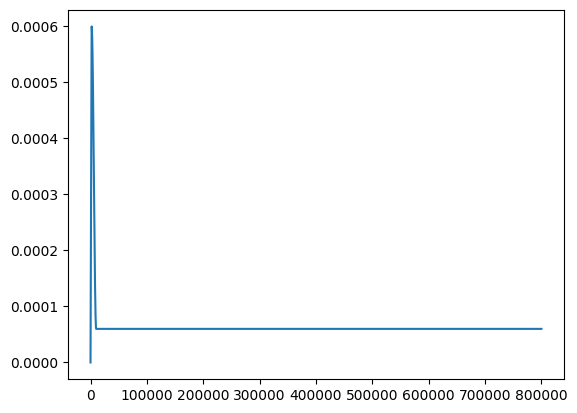

In [17]:
#### 4.3 learning rate settings
def get_lr(iter):
    # 1. linear warmup for warmup_iters steps
    if iter < warmup_iters:
        return learning_rate * (iter / warmup_iters)
    # 2. set the minimum lr when the iter more than decay iters
    if iter > lr_decay_iters:
        return min_lr
    # 3. in between, use cosine decay
    decay_ratio = (iter - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    # coeff ranges from 0-1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)
# show the lr plateau 
x_list = []
y_list = []
for i in range(800000):
    lr = get_lr(i)
    x_list.append(i)
    y_list.append(lr)
plt.plot(x_list,y_list)
plt.show()

In [18]:
#### 4.4 training loop
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            # mixed precison need to be closed
            with ctx:
                logits, loss = model(X, Y)
            # save the loss during each iter
            losses[k] = loss.item()
        # get the mean loss across one eval iteration
        out[split] = losses.mean()
    model.train()
    return out

while True:
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
    # evaluate the loss on train/val sets and write checkpoints
    # you may notice that this is the pre-checking step rather than training itself
    if iter_num % eval_interval == 0 and master_process:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        # if loss lower than best loss we set, we will update the loss to current loss
        if losses['val'] < best_val_loss or always_save_checkpoint:
            best_val_loss = losses['val']
            if iter_num > 0:
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'model_args': model_args,
                    'iter_num': iter_num,
                    'best_val_loss': best_val_loss,
                    'config': config,                    
                }

                print(f'saving checkpoint to {out_dir}')
                torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))
    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        if ddp:
            # in DDP training we only need to sync gradients at the last micro step.
            # the official way to do this is with model.no_sync() context manager, but
            # I really dislike that this bloats the code and forces us to repeat code
            # looking at the source of that context manager, it just toggles this variable.
            
            # only sync gradients at last
            # it means that if in ddp, we only need to forward pass when last step
            model.require_backward_grad_sync = (micro_step == gradient_accumulation_steps - 1 )
        with ctx:
            logits, loss = model(X, Y)
            loss = loss / gradient_accumulation_steps
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch('train')
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    
    # clip the gradient
    if grad_clip != 0.0:
        # if we choose to clip gradients, we need to unscale the gradients first to clip the right gradients
        scaler.unscale_(optimizer)
        # grad clip is the max gradients during training to avoid gradient explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging

    t1 = time.time()
    dt = t1 - t0
    t0 = t1

    # if not in ddp, we use this logging
    if iter_num  % log_interval == 0 and master_process:
        # get loss as float. note: this is a CPU-GPU sync point
        # scale up to undo the division above, approximating the true total loss (exact would have been a sum)
        lossf = loss.item() * gradient_accumulation_steps
        if local_iter_num >= 5:
            mfu = raw_model.estimate_mfu(batch_size * gradient_accumulation_steps, dt)
            # 0.9 and 0.1 can dynamticly adjust to monitor training flop
            running_mfu = mfu if running_mfu == -1.0 else 0.9*running_mfu + 0.1*mfu
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%")
    iter_num += 1
    local_iter_num += 1    
    # this notebool is just for presentation, so the max_iters will set to 10000, in raw project, it will be set to 600000.
    if iter_num > max_iters:
        break
    
# ddp needs init and destory
if ddp:
    destroy_process_group()

step 0: train loss 10.9656, val loss 10.9660
iter 0: loss 10.9638, time 55536.26ms, mfu -100.00%
iter 1: loss 10.9647, time 7416.97ms, mfu -100.00%
iter 2: loss 10.9601, time 7821.97ms, mfu -100.00%
iter 3: loss 10.9583, time 7846.93ms, mfu -100.00%
iter 4: loss 10.9416, time 7848.42ms, mfu -100.00%
iter 5: loss 10.9345, time 7869.55ms, mfu 17.11%
iter 6: loss 10.9007, time 7923.24ms, mfu 17.10%
iter 7: loss 10.8904, time 7965.74ms, mfu 17.08%
iter 8: loss 10.8722, time 7954.93ms, mfu 17.07%
iter 9: loss 10.8328, time 7916.41ms, mfu 17.06%
iter 10: loss 10.7939, time 7898.52ms, mfu 17.06%
iter 11: loss 10.7610, time 7889.97ms, mfu 17.06%
iter 12: loss 10.7198, time 7857.73ms, mfu 17.07%
iter 13: loss 10.6761, time 7867.32ms, mfu 17.07%
iter 14: loss 10.6430, time 7896.29ms, mfu 17.07%
iter 15: loss 10.5781, time 7947.35ms, mfu 17.06%
iter 16: loss 10.5249, time 7992.31ms, mfu 17.04%
iter 17: loss 10.4574, time 7995.89ms, mfu 17.02%
iter 18: loss 10.3811, time 7972.91ms, mfu 17.00%
iter

KeyboardInterrupt: 

#### 3.2 inference
During inference, we can utilize the sample method to generate responses for a trained model.

In [54]:
# we will not start from stratch like nanoGPT instead of inference with our trained model above.
# But one thing you need to konw is when we save the model.state_dict
# the module name would have a prefix '_orig_mod_'
show_state_dict = model.state_dict().items()
# just like: 
print(f'model raw state dict: \n{list(show_state_dict)[0]}')
# so when you load a model you trained before, you may remove the prefix and the detail is in nanoGPT repertory -> sample.py

#### 1. load encode and decode
# This step means we need to convert word into ids, such as: 'I love you' -> '<SOS> 5 2 0 <EOS>'
# there are two ways to complement that:
# 1. load meta
meta_path = os.path.join(data_dir, 'meta.pkl')
if os.path.exists(meta_path):
    with open(meta_path, 'rb+') as f:
        meta = pickle.load(f)
        print(f'get dataset meta alphabet information: \n{meta}')
        stoi, itos = meta['stoi'], meta['itos']
        encode = lambda s: [stoi[c] for c in s]
        decode = lambda l: [itos[i] for i in l]
else:
    # 2. load from tiktoken
    # ok let's assume gpt-2 encodings by default
    print("No meta.pkl found, assuming GPT-2 encodings...")
    enc = tiktoken.get_encoding('gpt2')
    encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
    decode = lambda l: enc.decode(l)

#### 2. inference
# assuming that we start at the very beginning
start = 'I love'
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None,...])

# inference config
# assuming that we need to generate 2 responses for a sample
sample_num = 10
# max tokens generate for a sample
max_new_tokens = 1
# temperature 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
temperature = 0.8
# top_k retain only the top_k most likely tokens, clamp others to have 0 probability
top_k = 10
# run generation
with torch.no_grad():
    with ctx:
        for k in range(sample_num):
            # NOTE you may notice that the nanoGPT `generate` method is in the GPT model
            # but I will put it as a independent method for better understanding
            """
            Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
            the sequence max_new_tokens times, feeding the predictions back into the model each time.
            Most likely you'll want to make sure to be in model.eval() mode of operation for this.
            """
            for _ in range(max_new_tokens):
                # if the sequence context is growing too long we must crop it at block_size
                idx_cond = x if x.size(1) <= gptconf.block_size else x[:, -gptconf.block_size:]
                # forward the model to get the logits for the index in the sequence
                logits, _ = model(idx_cond)
                # pluck the logits at the final step and scale by desired temperature
                logits = logits[:, -1, :] / temperature
                # optionally crop the logits to only the top k options
                if top_k is not None:
                    # torch.topk returns two variables: v means value and _ means indices
                    v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                    # v[:, [-1]] means select values in logits that all lower than v last dimension
                    logits[logits < v[:, [-1]]] = float('-inf')
                # apply softmax to convert logits to (normalized) probabilities
                probs = F.softmax(logits, dim = -1)
                # sample from the distribution, num_samples means sample a idx once and NOT the max prob idx must be sampled
                # to make sure diversity!
                idx_next = torch.multinomial(probs, num_samples=1)
                # append sampled index to the running sequence and continue
                x = torch.cat((x, idx_next), dim = -1)

            #### 3.output
            print(decode(x[0].tolist()))
            print('-------------------------')         

model raw state dict: 
('_orig_mod.transformer.wte.weight', tensor([[-0.0144, -0.0432, -0.0355,  ...,  0.0037, -0.0293, -0.0303],
        [-0.0176,  0.0060, -0.0204,  ..., -0.0106, -0.0338, -0.0159],
        [ 0.0446, -0.0146, -0.0076,  ...,  0.0023,  0.0303, -0.0201],
        ...,
        [-0.0003, -0.0093,  0.0030,  ..., -0.0067,  0.0018,  0.0263],
        [ 0.0176, -0.0502,  0.0234,  ..., -0.0665,  0.0055,  0.0134],
        [ 0.0312, -0.0296,  0.0299,  ..., -0.0214,  0.0347,  0.0068]],
       device='cuda:0'))
get dataset meta alphabet information: 
{'vocab_size': 65, 'itos': {0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: 'g', 46: 'h',